# Course Allocation to Students based on preference \[only\]
This jupyter notebook uses the Hospital Resident Matching algorithm to allocate courses to students according to their preferences only. The time when they indicated their choices/preferences should not be taken into account. While this does not necessarily always return the most stable matching (since the courses do not have any preference for students), it still reaches close to the actual solution. The way we modify the Hospital Resident Matching algorithm is as follows:
- We consider every student is equivalent to a resident having certain preferences for a subset of the hospitals.
- We consider every course is equivalent to a hospital having a capacity and a preference for the residents (students).
- Note that this preference of hospitals do not actually exist. We, therefore, synthetically create this ranking of students for a course based on the amount by which their score decreases (in decreasing order -- lower delta is ranked last) if they are removed unassigned from the given course. These students are further ranked by the current score they have (in increasing order -- highest score is ranked last).

In [1]:
# Importing necessary libraries
import alloc_structs
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# The random seed ensures reproducible results
seed = 92040706
random.seed(seed)
np.random.seed(seed)

# Reading the input data files
stud_data = pd.read_csv('data/students.csv', header=0)
cour_data = pd.read_csv('data/courses.csv', header=0)

max_courses = 6 # Maximum number of courses that may be allocated to a student
max_epoch = 10000 # Maximum iterations of the Hospital Resident assignment

## Investigating the input data available
### Student Data

In [2]:
# Displaying the student data
display(stud_data)

,Roll No.,Name,Number of courses they wish to take,First course preference,Second course preference,Third course preference,Fourth course preference,Fifth course preference,Sixth course preference
0,22510030,Demi Baldwin,3,MA 603-Nonlinear Analysis with Applications,ME 321-Mechanics of Deformable Bodies,CL 628-Liquid State Theory,MA 624-Partial Differential Equations,ES 415-Nature-inspired Materials Design,HS 649-Public Policy and its Impact Evaluation
1,22510221,Jaiden Wheeler,2,ES 243-Biology for Engineers,EH 614-Physics of the Lithosphere,ME 636-Fuel Cell and Battery Systems,MSE 310-Physics of Materials,NaN,NaN
2,19520735,Sydney Khan,2,CL 628-Liquid State Theory,ES 243-Biology for Engineers,MS 404-Neuromarketing,CL 604-Advanced Reaction Engineering,NaN,NaN
3,23520174,Kendrick Walsh,4,ES 623-Biomolecular Materials Science,EH 617-Advanced Field Techniques in Earth Scie...,ES 243-Biology for Engineers,ES 415-Nature-inspired Materials Design,NaN,NaN
4,21510520,Leia Hendrix,3,EH 614-Physics of the Lithosphere,MSE 209-Material Thermodynamics and Kinetics,MSE 401-Introduction to Polymer Physics and Pr...,MA 603-Nonlinear Analysis with Applications,ES 243-Biology for Engineers,NaN
...,...,...,...,...,...,...,...,...,...
995,21510247,Shepherd Hanna,4,HS 643-Indian and Western Cultural Theory,CL 221-Chemical Engineering Thermodynamics,CL 604-Advanced Reaction Engineering,MSE 401-Introduction to Polymer Physics and Pr...,ES 613-Modern Control Theory,ES 243-Biology for Engineers
996,21520171,Cynthia Skinner,3,ME 636-Fuel Cell and Battery Systems,MA 605-Commutative Algebra,CH 401-Food Chemistry,NaN,NaN,NaN
997,20110520,Ridge Walton,3,ME 321-Mechanics of Deformable Bodies,ME 636-Fuel Cell and Battery Systems,MSE 625-Thermodynamics of thin film growth,MSE 310-Physics of Materials,NaN,NaN
998,22110041,Scarlet Sanders,4,PH 607-Topics in Quantum and Statistical Mecha...,MA 603-Nonlinear Analysis with Applications,HS 643-Indian and Western Cultural Theory,ES 243-Biology for Engineers,MSE 401-Introduction to Polymer Physics and Pr...,HS 649-Public Policy and its Impact Evaluation


### Course Data

In [3]:
# Displaying the courses data
display(cour_data)

,Course Code,Course Name,Course Capacity
0,HS 643,Indian and Western Cultural Theory,60
1,ES 243,Biology for Engineers,50
2,HS 649,Public Policy and its Impact Evaluation,60
3,MSE 625,Thermodynamics of thin film growth,60
4,MA 603,Nonlinear Analysis with Applications,60
5,CG 506,Experimental Techniques in Cognitive Science,60
6,CL 628,Liquid State Theory,60
7,HS 632,A Multilingual Nation,40
8,PH 607,Topics in Quantum and Statistical Mechanics,50
9,ME 636,Fuel Cell and Battery Systems,40


## Making the instances of the student and course classes

In [4]:
# Loading Courses Data
courses = [alloc_structs.Course(cour_data.loc[i]['Course Code'], cour_data.loc[i]['Course Name'], cour_data.loc[i]['Course Capacity']) for i in cour_data.index]
course_dict = {}
for i, course in enumerate(courses):
    course_dict[course.code] = i

# Loading Students' Data
students = [alloc_structs.Student(stud_data.loc[i]['Roll No.'], stud_data.loc[i]['Name'], stud_data.loc[i]['Number of courses they wish to take'], [c[:c.index('-')] for c in stud_data.loc[i].values[3:] if pd.notna(c)]) for i in stud_data.index]
student_dict = {}
for i, stud in enumerate(students):
    student_dict[stud.roll] = i

## The Hospital Resident Matching Algorithm:
- If the course preferred by the student can be assigned to them (there is some finite, non-negative remaining capacity for the course), it is allocated to the student.
- If there is no remaining capacity, the least preferred student by the course is compared to the current student.
- If both students will be ranked equally, one of them is randomly (uniformly) selected to be allocated the course.

In [5]:
courses_in_consideration = [i for i in range(len(courses))] # Change if you want to selectively allocate some courses
students_in_consideration = [i for i in range(len(students))] # Change if you want to selectively assign some students
unassigned_students = [i for i in students_in_consideration]

assign_no = 0
while len(unassigned_students) > 0 and assign_no < max_courses:
    total_score = 0
    epoch = 0
    print(f'#{assign_no+1} Assignment:')
    while len(unassigned_students) > 0 and epoch < max(max_epoch, 2*len(students_in_consideration)):
        lucky_student = random.choice(unassigned_students) # Student being allocated a course
        for pref in students[lucky_student].course_preferences:
            # If most preferred course has remaining capacity
            if courses[course_dict[pref]].r_cap > 0:
                courses[course_dict[pref]].add_student(students[lucky_student])
                unassigned_students.remove(lucky_student)
                total_score += students[lucky_student].temp_score
                break
            # If the current student is preferred to the least preferred temporarily allocated student in the course
            elif len(courses[course_dict[pref]].temp_assigned_students) > 0 and (len(courses[course_dict[pref]].temp_assigned_students[-1].course_preferences) > len(students[lucky_student].course_preferences) or (len(courses[course_dict[pref]].temp_assigned_students[-1].course_preferences) == len(students[lucky_student].course_preferences) and courses[course_dict[pref]].temp_assigned_students[-1].temp_score > students[lucky_student].temp_score)) :
                total_score -= students[student_dict[courses[course_dict[pref]].temp_assigned_students[-1].roll]].temp_score
                courses[course_dict[pref]].popularity_index += students[student_dict[courses[course_dict[pref]].temp_assigned_students[-1].roll]].temp_score / students[student_dict[courses[course_dict[pref]].temp_assigned_students[-1].roll]].desired_n
                unlucky_student = courses[course_dict[pref]].remove_last()
                unassigned_students.append(student_dict[unlucky_student])
                courses[course_dict[pref]].add_student(students[lucky_student])
                unassigned_students.remove(lucky_student)
                total_score += students[lucky_student].temp_score
                break
            # If the current student is equally preferred as the least preferred temporarily allocated student in the course then with probability half
            elif len(courses[course_dict[pref]].temp_assigned_students) > 0 and len(courses[course_dict[pref]].temp_assigned_students[-1].course_preferences) == len(students[lucky_student].course_preferences) and courses[course_dict[pref]].temp_assigned_students[-1].temp_score == students[lucky_student].temp_score and random.choice([0, 1]) == 1:
                total_score -= students[student_dict[courses[course_dict[pref]].temp_assigned_students[-1].roll]].temp_score
                courses[course_dict[pref]].popularity_index += students[student_dict[courses[course_dict[pref]].temp_assigned_students[-1].roll]].temp_score / students[student_dict[courses[course_dict[pref]].temp_assigned_students[-1].roll]].desired_n
                unlucky_student = courses[course_dict[pref]].remove_last()
                unassigned_students.append(student_dict[unlucky_student])
                courses[course_dict[pref]].add_student(students[lucky_student])
                unassigned_students.remove(lucky_student)
                total_score += students[lucky_student].temp_score
                break
        epoch += 1
        if epoch%2000==0:
            print(f'\t#{epoch} epoch: \tSatisfaction score = {total_score}')
    # Marking all allocations as permanent
    for course in courses_in_consideration:
        courses[course].fixate()
    # Finding next set of unassigned students
    unassigned_students = [i for i in students_in_consideration if students[i].desired_n > students[i].actual_n and len(students[i].course_preferences) > 0]
    assign_no += 1

#1 Assignment:
#2 Assignment:
	#2000 epoch: 	Satisfaction score = 27474.99999999999
	#4000 epoch: 	Satisfaction score = 27678.33333333332
	#6000 epoch: 	Satisfaction score = 27678.33333333332
	#8000 epoch: 	Satisfaction score = 27678.33333333332
	#10000 epoch: 	Satisfaction score = 27678.33333333332
#3 Assignment:
	#2000 epoch: 	Satisfaction score = 683.3333333333334
	#4000 epoch: 	Satisfaction score = 683.3333333333334
	#6000 epoch: 	Satisfaction score = 683.3333333333334
	#8000 epoch: 	Satisfaction score = 683.3333333333334
	#10000 epoch: 	Satisfaction score = 683.3333333333334
#4 Assignment:
	#2000 epoch: 	Satisfaction score = 0
	#4000 epoch: 	Satisfaction score = 0
	#6000 epoch: 	Satisfaction score = 0
	#8000 epoch: 	Satisfaction score = 0
	#10000 epoch: 	Satisfaction score = 0
#5 Assignment:
	#2000 epoch: 	Satisfaction score = 0
	#4000 epoch: 	Satisfaction score = 0
	#6000 epoch: 	Satisfaction score = 0
	#8000 epoch: 	Satisfaction score = 0
	#10000 epoch: 	Satisfaction score = 0
#

## Data Visualization
Let us peek into the score distribution. In almost all instances it has performed better than classical methods like a first-come-first-serve based allocation (We do not make that comparison in this notebook; however, one can try out for themselves and verify this on their custom dataset). Ideally, we want a high mean satisfaction score and a low standard deviation for the score distribution.

In [6]:
# Peeking into the score distribution
scores = np.array([stud.score for stud in students])
print(f'The minimum score is {scores.min()}')
print(f'The maximum score is {scores.max()}')
print(f'The mean satisfaction score is {scores.mean()}')
print(f'The standard deviation of the scores is {scores.std()}')

The minimum score is 16.666666666666668
The maximum score is 100.0
The mean satisfaction score is 60.80388888888889
The standard deviation of the scores is 28.822022995756235


The histogram helps visualize the distribution and makes evident that a huge chunk of the students have been allocated their exact preference (100% satisfaction score). Among the rest, most of the students lie in the range of 30%-50% satisfaction scores.

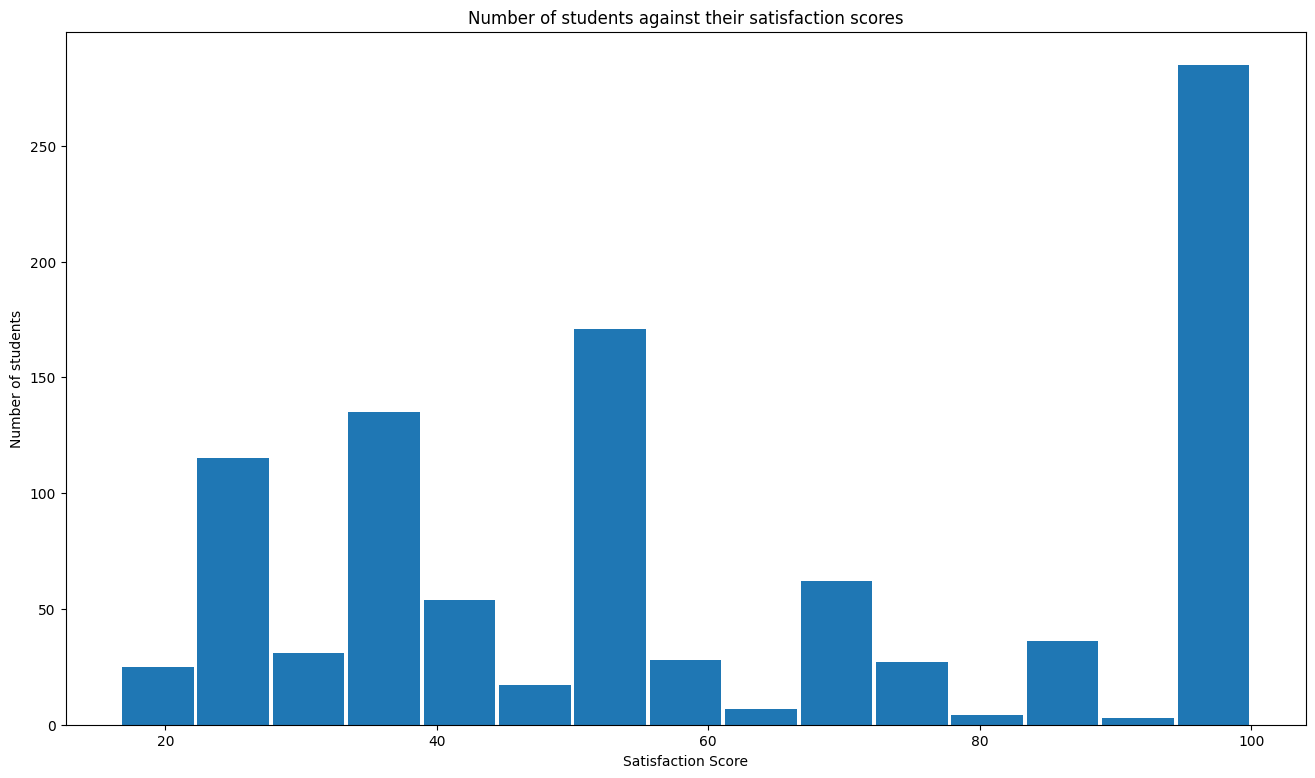

In [7]:
# Plotting a histogram to visualize the score distribution
plt.figure(1, (16, 9))
plt.title(f'Number of students against their satisfaction scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Number of students')
plt.hist(scores, bins = 15, histtype='barstacked', rwidth=0.95)
plt.show()

Let us now take a look into the most popular courses (determined by a measure based on the score by which the mean score could've been increased). Here, we only look at the top three courses. Note that this might drastically change when we choose to change the capacity of either of the courses.

In [8]:
# Looking into the most popular courses
sorted_courses = courses.copy()
sorted_courses.sort(key=lambda x:x.popularity_index, reverse=True)
print(*sorted_courses[:3], sep='\n\n')

Code:						MSE 401
Name:						Introduction to Polymer Physics and Processing
Capacity:					40
Allocated Number:			40
Supernumerarily Allocated:	0

Code:						ES 623
Name:						Biomolecular Materials Science
Capacity:					50
Allocated Number:			50
Supernumerarily Allocated:	0

Code:						CL 604
Name:						Advanced Reaction Engineering
Capacity:					40
Allocated Number:			40
Supernumerarily Allocated:	0


## Saving as files
Here, we simply save the allocation done into .csv files for future reference.

In [9]:
# Saving the student-wise allocation file
output = pd.DataFrame(stud_data[['Roll No.', 'Name']]).set_index('Roll No.')
al_courses = []
for roll in output.index:
    al_courses.append(list(map(lambda x: x.code, students[student_dict[roll]].allocated_courses)))
output['Allocated Courses'] = pd.Series(al_courses).values
output.to_csv('data/student_wise_allocation.csv')

In [10]:
# Saving the course-wise assignment file
output = cour_data.set_index('Course Code')
al_stud = []
al_n = []
for code in output.index:
    al_stud.append(list(map(lambda x: x.roll, courses[course_dict[code]].perm_assigned_students)))
    al_n.append(courses[course_dict[code]].cap-courses[course_dict[code]].r_cap+courses[course_dict[code]].sn)
output['Number of assigned Students'] = pd.Series(al_n).values
output['Assigned Students'] = pd.Series(al_stud).values
output.to_csv('data/course_wise_assignment.csv')